# `Cartopy` 地图绘制（2）
![](https://scitools.org.uk/cartopy/docs/latest/_static/cartopy.png)

**Carto**graphy **Py**thon

------------------------

主讲人：李显祥

大气科学学院

## 地图背景 - 天地图

In [1]:
from IPython.display import IFrame
web = IFrame(src='https://www.tianditu.gov.cn/index.html', width=1000, height=500)
display(web)

- 天地图（和其它很多种地图服务）都采用 Web Map Tile Service (WMTS) 来提供地图服务。 
- 常用的有 Google，OpenStreetMap等
- 国内有百度、高德等

由于它们都遵循相同的规范，我们可以通过修改 `cartopy` 中已有的 Google 地图类来实现天地图的调用。

天地图需要注册获得token才能使用。请将你的token赋给变量 `token`，再开始运行下面的代码。

In [2]:
import matplotlib.pyplot as plt
import cartopy.io.img_tiles as cimgt
import cartopy.crs as ccrs
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from urllib.request import Request

class TDT(cimgt.GoogleWTS):
    def _image_url(self, tile):
        x, y, z = tile
        tk = token
        url = 'http://t3.tianditu.gov.cn/DataServer?T=vec_w&x=%s&y=%s&l=%s&tk=%s'% (x, y, z, tk)
        url = Request(url,headers={'User-Agent': 'Mozilla/5.0'})
        return url
class TDT_ter(cimgt.GoogleWTS):
    def _image_url(self, tile):
        x, y, z = tile
        tk = token
        url = 'http://t3.tianditu.gov.cn/DataServer?T=ter_w&x=%s&y=%s&l=%s&tk=%s'% (x, y, z, tk)
        url = Request(url,headers={'User-Agent': 'Mozilla/5.0'})
        return url
class TDT_img(cimgt.GoogleWTS):
    def _image_url(self, tile):
        x, y, z = tile
        tk = token
        url = 'http://t3.tianditu.gov.cn/DataServer?T=img_w&x=%s&y=%s&l=%s&tk=%s'% (x, y, z, tk)
        url = Request(url,headers={'User-Agent': 'Mozilla/5.0'})
        return url

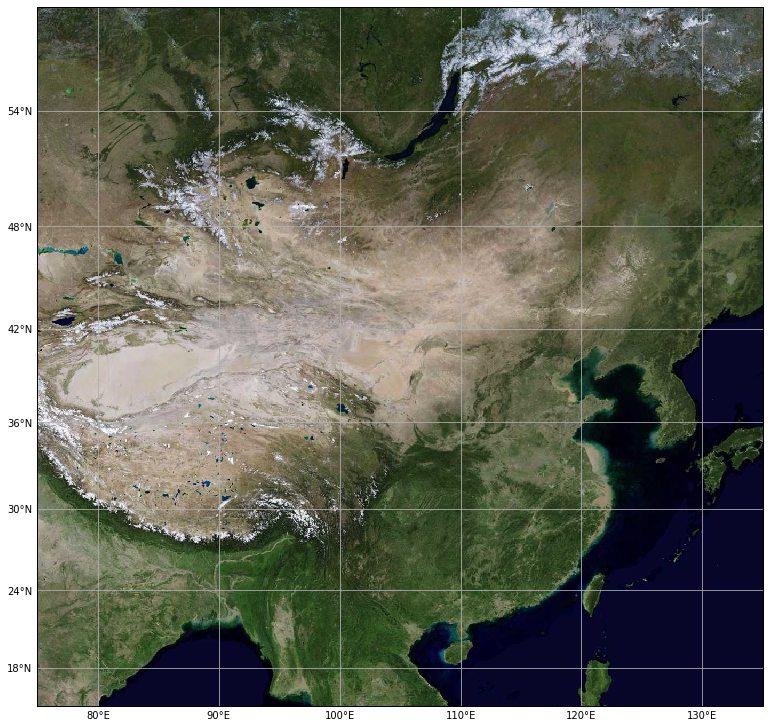

In [3]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(13, 13),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

extent = [75, 135, 15, 55] #21.5, 23.5] #广东图
#request = TDT() #矢量图层
request = TDT_img() #影像
#request = TDT_ter() #地形
fig, ax = make_map(projection=request.crs)
ax.set_extent(extent)
ax.add_image(request, 5)# level=10 缩放等级 

## 绘制台风路线

In [4]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.io.img_tiles as cimgt
import cartopy.feature as cfeat
from cartopy.io.shapereader import Reader
import pandas as pd
import os
from PIL import Image

%matplotlib inline

In [5]:
def make_plot(WTS,level):
    extent = [72, 135, 15, 54]
    shp= '../shp_file/china.shp'
    proj = ccrs.PlateCarree()
    
    fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(projection=WTS.crs))
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.set_extent(extent)
    ax.add_image(WTS, level) 
    reader = Reader(shp)
    provinces = cfeat.ShapelyFeature(reader.geometries(),proj, edgecolor='white', facecolor='none')
    ax.add_feature(provinces, edgecolor='w',linewidth=1) 
    sub_extent = [105, 125, 0, 25]
    sub_ax = fig.add_axes([0.66, 0.13, 0.135, 0.155], projection=WTS.crs)
    sub_ax.set_extent(sub_extent)
    sub_ax.add_image(WTS, level) 
    sub_ax.add_feature(provinces, edgecolor='w',linewidth=1)
    return fig,ax,sub_ax

In [6]:
typhoon = pd.read_csv("1909.csv")
typhoon.dropna(subset=['wind'],inplace=True)
typhoon = typhoon.reset_index()
typhoon['class'] = ''
typhoon.loc[(typhoon['wind']>=10.8) & (typhoon['wind']<=17.1),'class'] = 'TROPICAL DEPRESSION'
typhoon.loc[(typhoon['wind']>17.2) & (typhoon['wind']<=24.4),'class'] = 'TROPICAL STORM'
typhoon.loc[(typhoon['wind']>24.5) & (typhoon['wind']<=32.6),'class'] = "SEVERE TROPICAL STORM"
typhoon.loc[(typhoon['wind']>32.7) & (typhoon['wind']<=41.4),'class'] = "TYPHOON"
typhoon.loc[(typhoon['wind']>41.5) & (typhoon['wind']<=50.9),'class'] = "SEVERE TYPHOON"
typhoon.loc[(typhoon['wind']>51),'class']="SUPER TYPHOON"
#color_dict = {'TROPICAL DEPRESSION': '#7fffd4', 'TROPICAL STORM': '#008000', "SEVERE TROPICAL STORM": '#0000ff', 
#              "TYPHOON": '#ffff00', "SEVERE TYPHOON": '#ffa500', "SUPER TYPHOON": '#ff4500'}
color_dict = {'TROPICAL DEPRESSION': 'lime', 'TROPICAL STORM': 'blue', "SEVERE TROPICAL STORM": 'yellow', 
              "TYPHOON": 'orange', "SEVERE TYPHOON": 'red', "SUPER TYPHOON": 'darkred'}

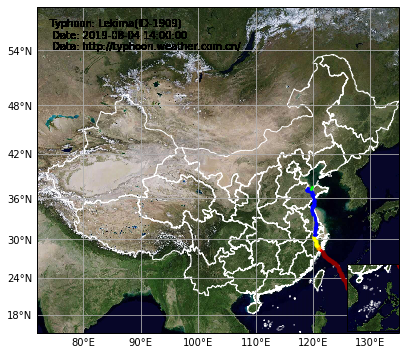

In [7]:
wts = TDT_img()  
fig,ax,sub_ax = make_plot(wts,5)

for i in typhoon.index[:-1]:
    a0, b0 = typhoon.loc[i,"lon"], typhoon.loc[i,"lat"]
    a1, b1 = typhoon.loc[i+1,"lon"], typhoon.loc[i+1,"lat"]
            
    ax.plot((a0,a1),(b0,b1), linewidth=2.5,color=color_dict[typhoon.loc[i+1,"class"]], 
                transform=ccrs.Geodetic())
    ax.scatter(a0, b0, s=10, c=color_dict[typhoon.loc[i,"class"]], alpha=0.8, 
                transform=ccrs.Geodetic())
    sub_ax.plot((a0,a1),(b0,b1), linewidth=2.5,
                color=color_dict[typhoon.loc[i+1,"class"]], transform=ccrs.Geodetic())
    sub_ax.scatter(a0, b0, s=10, c=color_dict[typhoon.loc[i,"class"]], 
                alpha=0.8, transform=ccrs.Geodetic())
        
    ax.annotate('Typhoon: %s\n Date: %s\n Data: http://typhoon.weather.com.cn/\n' % ('Lekima(ID-1909)', "2019-08-04 14:00:00"),
            xy=(0, 1), xytext=(12, -12), va='top', ha='left',xycoords='axes fraction', textcoords='offset points')

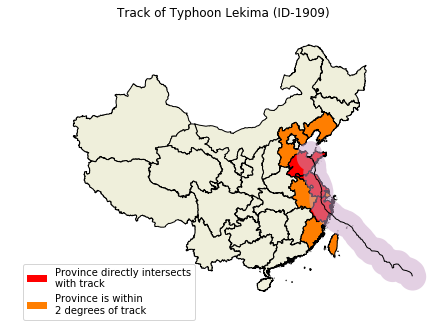

In [8]:
# 参考 https://scitools.org.uk/cartopy/docs/latest/gallery/hurricane_katrina.html
import shapely.geometry as sgeom
import matplotlib.patches as mpatches

lons, lats = typhoon['lon'].values, typhoon['lat'].values

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal(central_longitude=105, central_latitude=90,
                             false_easting=400000, false_northing=400000))

ax.set_extent([72, 135, 15, 54], ccrs.Geodetic())
    
shp= '../shp_file/china.shp'
reader = Reader(shp)
#provinces = cfeat.ShapelyFeature(reader.geometries(),proj, edgecolor='white', facecolor='none')
    
# to get the effect of having just the provinces without a map "background"
# turn off the outline and background patches
ax.background_patch.set_visible(False)
ax.outline_patch.set_visible(False)

ax.set_title('Track of Typhoon Lekima (ID-1909)')

# turn the lons and lats into a shapely LineString
track = sgeom.LineString(zip(lons, lats))
# buffer the linestring by two degrees (note: this is a non-physical distance)
track_buffer = track.buffer(2)

def colorize_province(geometry):
    facecolor = (0.9375, 0.9375, 0.859375)
    if geometry.intersects(track):
        facecolor = 'red'
    elif geometry.intersects(track_buffer):
        facecolor = '#FF7E00'
    return {'facecolor': facecolor, 'edgecolor': 'black'}

ax.add_geometries(reader.geometries(),
        ccrs.PlateCarree(),
        styler=colorize_province)

ax.add_geometries([track_buffer], ccrs.PlateCarree(),
                      facecolor='#C8A2C8', alpha=0.5)
ax.add_geometries([track], ccrs.PlateCarree(),
                      facecolor='none', edgecolor='k')

# make two proxy artists to add to a legend
direct_hit = mpatches.Rectangle((0, 0), 1, 1, facecolor="red")
within_2_deg = mpatches.Rectangle((0, 0), 1, 1, facecolor="#FF7E00")
labels = ['Province directly intersects\nwith track',
            'Province is within \n2 degrees of track']
ax.legend([direct_hit, within_2_deg], labels,
            loc='lower left', bbox_to_anchor=(0.025, -0.1), fancybox=True)

2018-22台风山竹

![](2018-22_Mangkhut.png)

## 天地图的标记图层

- 天地图的标记和边界图层都是透明的，可以叠加在矢量、图像或地形图层上。
- 需要使用 `desired_tile_form='RGBA'` 选项。
- 需要设置背景为 `invisible`。

In [9]:
class TDT_e_label(cimgt.GoogleWTS):
    '''
     带英文标注的矢量图
    ''' 
    def _image_url(self, tile):
        x, y, z = tile
        tk = token
        url = 'http://t3.tianditu.gov.cn/DataServer?T=eva_w&x=%s&y=%s&l=%s&tk=%s'% (x, y, z, tk)
        url = Request(url,headers={'User-Agent': 'Mozilla/5.0'})
        return url

In [10]:
class TDT_c_label(cimgt.GoogleWTS):
    '''
     带中文标注的矢量图
    ''' 
    def _image_url(self, tile):
        x, y, z = tile
        tk = token
        url = 'http://t3.tianditu.gov.cn/DataServer?T=cva_w&x=%s&y=%s&l=%s&tk=%s'% (x, y, z, tk)
        url = Request(url,headers={'User-Agent': 'Mozilla/5.0'})
        return url

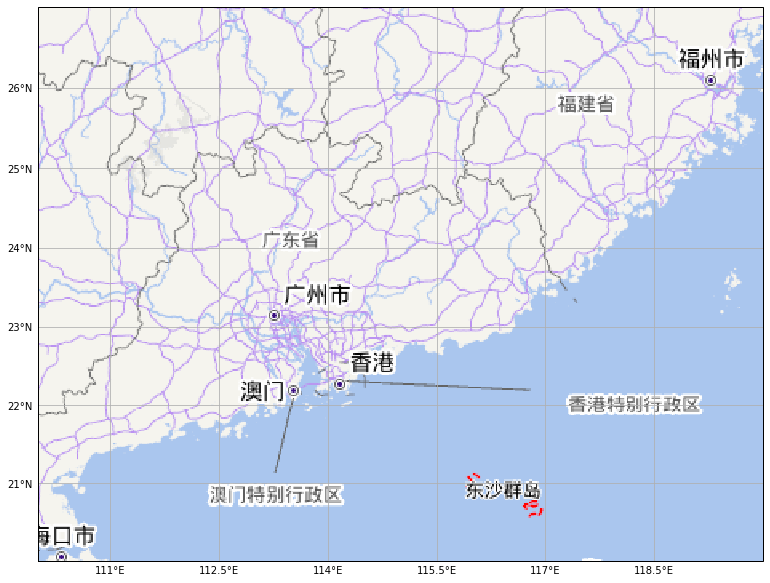

In [11]:
# Reference: https://github.com/SciTools/cartopy/issues/762
extent = [110, 120, 20, 27] #广东图
request = TDT() #矢量图层
request_l = TDT_c_label(desired_tile_form='RGBA') #矢量图层的标注
#print(type(request_l))
#request = TDT_ter() #地形
fig, ax = make_map(projection=request.crs)
ax.background_patch.set_visible(False)
ax.set_extent(extent)
ax.add_image(request, 6)# level=10 缩放等级  
ax.add_image(request_l, 6)

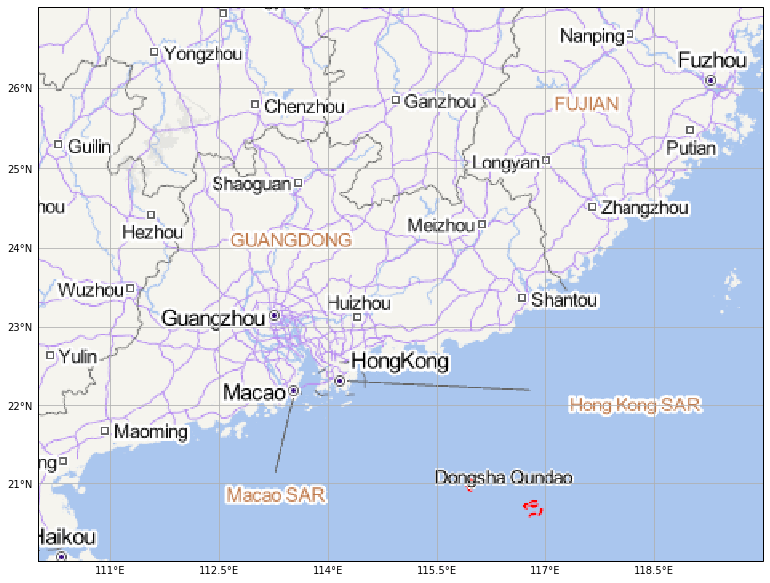

In [12]:
# Reference: https://github.com/SciTools/cartopy/issues/762
extent = [110, 120, 20, 27] #广东图
request = TDT() #矢量图层
request_l = TDT_e_label(desired_tile_form='RGBA') #矢量图层的标注
#print(type(request_l))
#request = TDT_ter() #地形
fig, ax = make_map(projection=request.crs)
ax.background_patch.set_visible(False)
ax.set_extent(extent)
ax.add_image(request, 6)# level=10 缩放等级 
ax.add_image(request_l, 6)

## 天地图边界线图层

In [13]:
class TDT_borders(cimgt.GoogleWTS):
    '''
     全球境界
    ''' 
    def _image_url(self, tile):
        x, y, z = tile
        tk = token
        url = 'http://t3.tianditu.gov.cn/DataServer?T=ibo_w&x=%s&y=%s&l=%s&tk=%s'% (x, y, z, tk)
        url = Request(url,headers={'User-Agent': 'Mozilla/5.0'})
        return url

同时叠加天地图的边界线和 NaturalEarth 边界线，注意两者的区别。

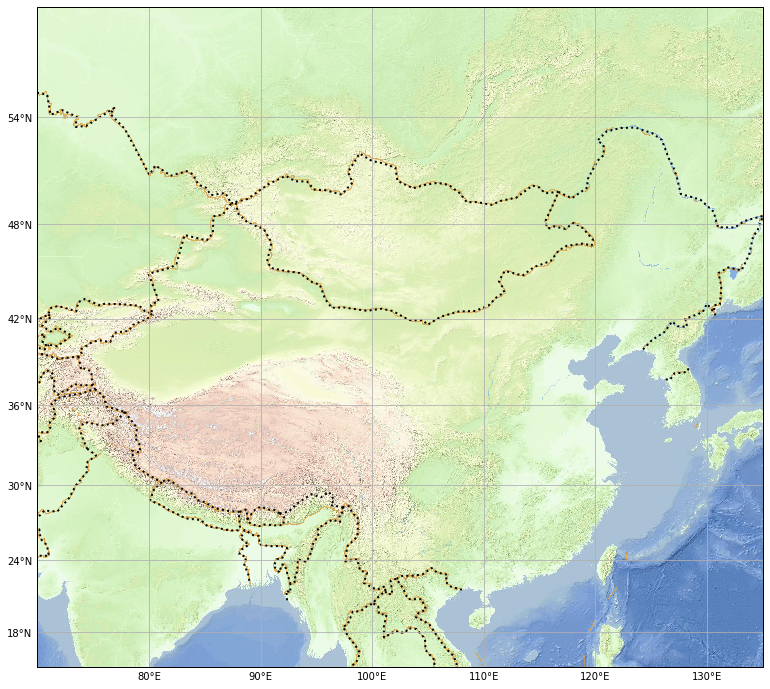

In [14]:
extent = [70, 135, 15, 55] #广东图
#request = TDT() #矢量图层
request_l = TDT_borders(desired_tile_form='RGBA')
#print(type(request_l))
request = TDT_ter() #地形

fig, ax = make_map(projection=request.crs)
# 为了显示边界层，必须设置此项
ax.background_patch.set_visible(False)
ax.set_extent(extent)
#ax.set_global()
ax.add_image(request, 5)# level=10 缩放等级 
ax.add_image(request_l, 5)
ax.add_feature(cfeat.BORDERS, linestyle=':', linewidth=2)

## 绘制 NASA 晚间灯光数据

In [15]:
# from https://stackoverflow.com/questions/58377561/cartopy-wmts-keyerror-issue-tilematrixlimits
### START REPLACEMENT ###

from owslib.wmts import TileMatrixSetLink, TileMatrixLimits, _TILE_MATRIX_SET_TAG, _TILE_MATRIX_SET_LIMITS_TAG, _TILE_MATRIX_LIMITS_TAG

def custom_from_elements(link_elements):
    links = []
    for link_element in link_elements:
        matrix_set_elements = link_element.findall(_TILE_MATRIX_SET_TAG)
        if len(matrix_set_elements) == 0:
            raise ValueError('Missing TileMatrixSet in %s' % link_element)
        elif len(matrix_set_elements) > 1:
            set_limits_elements = link_element.findall(
                _TILE_MATRIX_SET_LIMITS_TAG)
            if set_limits_elements:
                raise ValueError('Multiple instances of TileMatrixSet'
                                  ' plus TileMatrixSetLimits in %s' %
                                  link_element)
            for matrix_set_element in matrix_set_elements:
                uri = matrix_set_element.text.strip()
                links.append(TileMatrixSetLink(uri))
        else:
            uri = matrix_set_elements[0].text.strip()

            tilematrixlimits = {}
            path = '%s/%s' % (_TILE_MATRIX_SET_LIMITS_TAG,
                              _TILE_MATRIX_LIMITS_TAG)
            for limits_element in link_element.findall(path):
                tml = TileMatrixLimits(limits_element)
                if tml.tilematrix:
                    tilematrixlimits[tml.tilematrix] = tml

            links.append(TileMatrixSetLink(uri, tilematrixlimits))
    return links

TileMatrixSetLink.from_elements = custom_from_elements

### END REPLACEMENT ###

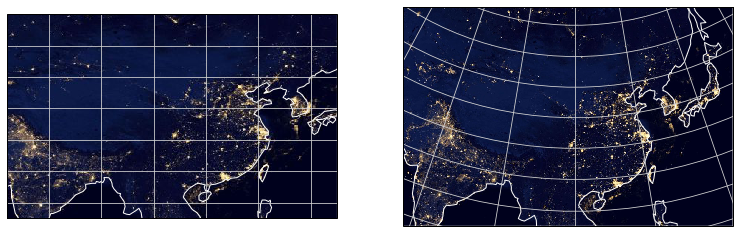

In [16]:
# Define resource for the NASA night-time illumination data. 
base_uri = 'http://map1c.vis.earthdata.nasa.gov/wmts-geo/wmts.cgi' 
layer_name = 'VIIRS_CityLights_2012'  

extent = [72, 135, 15, 54] #[90,130,15,50] 

# Create a Cartopy crs for plain and rotated lat-lon projections. 
plain_crs = ccrs.PlateCarree() 
lambert_crs = ccrs.LambertConformal(central_longitude=105, central_latitude=90, 
                              false_easting=400000, false_northing=400000) 
 
fig = plt.figure(figsize=(13,5)) 
 
# Plot WMTS data in a specific region, over a plain lat-lon map. 
ax = fig.add_subplot(1, 2, 1, projection=plain_crs) 
ax.set_extent(extent, crs=ccrs.PlateCarree()) 
ax.coastlines(resolution='110m', color='w') 
ax.gridlines(color='lightgrey', linestyle='-') 
# Add WMTS imaging. 
ax.add_wmts(base_uri, layer_name=layer_name) 
  
# Plot WMTS data on a rotated map, over the same nominal region. 
ax = fig.add_subplot(1, 2, 2, projection=lambert_crs) 
ax.set_extent(extent, crs=ccrs.PlateCarree()) 
ax.coastlines(resolution='110m', color='w') 
ax.gridlines(color='lightgrey', linestyle='-') 
# Add WMTS imaging. 
ax.add_wmts(base_uri, layer_name=layer_name)          

查看 NASA 有多少类似的服务

In [17]:
from owslib.wmts import WebMapTileService

wmts = WebMapTileService("http://map1c.vis.earthdata.nasa.gov/wmts-geo/wmts.cgi")

wmts.contents.keys()

dict_keys(['AMSR2_Cloud_Liquid_Water_Day', 'AMSR2_Cloud_Liquid_Water_Night', 'AMSR2_Surface_Precipitation_Rate_Day', 'AMSR2_Surface_Precipitation_Rate_Night', 'AMSR2_Surface_Rain_Rate_Day', 'AMSR2_Surface_Rain_Rate_Night', 'AMSR2_Wind_Speed_Day', 'AMSR2_Wind_Speed_Night', 'AMSR2_Columnar_Water_Vapor_Day', 'AMSR2_Columnar_Water_Vapor_Night', 'AMSRE_Brightness_Temp_89H_Day', 'AMSRE_Brightness_Temp_89H_Night', 'AMSRE_Brightness_Temp_89V_Day', 'AMSRE_Brightness_Temp_89V_Night', 'AMSRE_Surface_Precipitation_Rate_Day', 'AMSRE_Surface_Precipitation_Rate_Night', 'AMSRE_Surface_Rain_Rate_Day', 'AMSRE_Surface_Rain_Rate_Night', 'AMSRE_Sea_Ice_Concentration_12km', 'AMSRE_Snow_Depth_Over_Ice', 'AMSRE_Sea_Ice_Concentration_25km', 'AMSRE_Sea_Ice_Brightness_Temp_89H', 'AMSRE_Sea_Ice_Brightness_Temp_89V', 'AIRS_L2_Methane_400hPa_Volume_Mixing_Ratio_Day', 'AIRS_L2_Methane_400hPa_Volume_Mixing_Ratio_Night', 'AIRS_L2_Carbon_Monoxide_500hPa_Volume_Mixing_Ratio_Day', 'AIRS_L2_Carbon_Monoxide_500hPa_Volume_M

对于某些服务，我们可以指定某个时间以获得该时间的图像：

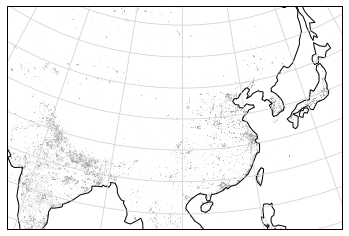

In [18]:
base_uri = 'http://map1c.vis.earthdata.nasa.gov/wmts-geo/wmts.cgi'  
layer_name = 'VIIRS_Night_Lights'   
 
extent = [72, 135, 15, 54] #[90,130,15,50]  

lambert_crs = ccrs.LambertConformal(central_longitude=105, central_latitude=90,  
                             false_easting=400000, false_northing=400000)  

fig = plt.figure(figsize=(6,5))  

ax = fig.add_subplot(projection=lambert_crs)  
ax.set_extent(extent, crs=ccrs.PlateCarree())  
ax.coastlines(resolution='110m', color='k')  
ax.gridlines(color='lightgrey', linestyle='-')  
# Add WMTS imaging.  
ax.add_wmts(base_uri, layer_name=layer_name, wmts_kwargs={'time':'2016-12-31'})      

我们可以画一下月平均气温，并用天地图叠加国境线：

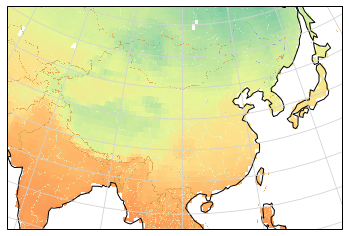

In [19]:
base_uri = 'http://map1c.vis.earthdata.nasa.gov/wmts-geo/wmts.cgi' 
layer_name = 'GLDAS_Near_Surface_Air_Temperature_Monthly' #'MODIS_Combined_Value_Added_AOD'  

extent = [72, 135, 15, 54] #[90,130,15,50] 
lambert_crs = ccrs.LambertConformal(central_longitude=105, central_latitude=90, 
                              false_easting=400000, false_northing=400000) 

fig = plt.figure(figsize=(6,5)) 
 
# Plot WMTS data in a specific region, over a plain lat-lon map. 
ax = fig.add_subplot(projection=lambert_crs) 
ax.set_extent(extent, crs=ccrs.PlateCarree()) 
ax.background_patch.set_visible(False)

ax.coastlines(resolution='110m', color='k') 
ax.gridlines(color='lightgrey', linestyle='-') 
# Add WMTS imaging. 
ax.add_wmts(base_uri, layer_name=layer_name) 

request_l = TDT_borders(desired_tile_form='RGBA')

ax.add_image(request_l, 5)